In [ ]:
import zipfile
import os

zip_path = 'archive.zip'  # Replace with your zip file path
extract_dir = 'btds'  # Replace with the directory where you want to extract

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete!")


Extraction complete!


In [ ]:
import os

# List files in the extracted folder
extracted_path = 'btds'
for root, dirs, files in os.walk(extracted_path):
    for file in files:
        print(os.path.join(root, file))


Streaming output truncated to the last 5000 lines.
btds/Training/glioma/Tr-gl_0801.jpg
btds/Training/glioma/Tr-gl_1143.jpg
btds/Training/glioma/Tr-gl_1160.jpg
btds/Training/glioma/Tr-gl_0706.jpg
btds/Training/glioma/Tr-gl_0668.jpg
btds/Training/glioma/Tr-gl_0913.jpg
btds/Training/glioma/Tr-gl_0946.jpg
btds/Training/glioma/Tr-gl_1089.jpg
btds/Training/glioma/Tr-gl_0721.jpg
btds/Training/glioma/Tr-gl_0257.jpg
btds/Training/glioma/Tr-gl_0369.jpg
btds/Training/glioma/Tr-gl_1012.jpg
btds/Training/glioma/Tr-gl_1315.jpg
btds/Training/glioma/Tr-gl_0175.jpg
btds/Training/glioma/Tr-gl_0552.jpg
btds/Training/glioma/Tr-gl_0180.jpg
btds/Training/glioma/Tr-gl_0356.jpg
btds/Training/glioma/Tr-gl_0102.jpg
btds/Training/glioma/Tr-gl_0761.jpg
btds/Training/glioma/Tr-gl_0978.jpg
btds/Training/glioma/Tr-gl_0704.jpg
btds/Training/glioma/Tr-gl_0271.jpg
btds/Training/glioma/Tr-gl_0712.jpg
btds/Training/glioma/Tr-gl_0121.jpg
btds/Training/glioma/Tr-gl_0011.jpg
btds/Training/glioma/Tr-gl_0615.jpg
btds/Training

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, BatchNormalization, Activation, Conv2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D, DepthwiseConv2D, ReLU, Softmax, Add
from tensorflow.keras.activations import softmax, relu, gelu


In [ ]:
def patch_embedding(input_shape, patch_size):
    inputs = layers.Input(shape=input_shape)
    patches = layers.Conv2D(filters=64, kernel_size=(patch_size, patch_size), strides=(patch_size, patch_size))(inputs)
    return models.Model(inputs=inputs, outputs=patches)


In [ ]:
def conv_mixer_block(patches, filters=256, kernel_size=9):
    x = DepthwiseConv2D(kernel_size=(kernel_size, kernel_size), padding='same')(patches)
    x = BatchNormalization()(x)
    x = gelu(x)
    x = Conv2D(filters, kernel_size=1)(x)
    x = BatchNormalization()(x)
    x = gelu(x)
    return x


In [ ]:
def self_attention_block(patches, num_heads=4, output_channels=256):
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)(patches, patches)
    attention_output = layers.Conv2D(output_channels, kernel_size=1)(attention_output)  # Match channels
    x = layers.Add()([patches, attention_output])
    x = layers.LayerNormalization()(x)
    return x


In [ ]:
def external_attention_block(patches, filters=256):
    external_memory = layers.Dense(filters)(patches)
    attention_output = layers.Dense(filters)(external_memory)
    attention_output = layers.Conv2D(filters, kernel_size=1)(attention_output)  # Match channels
    x = layers.Add()([patches, attention_output])
    x = layers.LayerNormalization()(x)
    return x


In [ ]:
def squeeze_excitation_block(x, ratio=16):
    filters = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    x = layers.Multiply()([x, se])
    return x

def classification_head(patches, num_classes=4):
    x = squeeze_excitation_block(patches)
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    return x


In [ ]:
def unet_with_all_features(input_shape=(224, 224, 3), num_classes=4, base_filters=64):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = conv_mixer_block(inputs, filters=base_filters)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_mixer_block(p1, filters=base_filters * 2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_mixer_block(p2, filters=base_filters * 4)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_mixer_block(p3, filters=base_filters * 8)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_mixer_block(p4, filters=base_filters * 16)

    # Add external attention in bottleneck
    ea = external_attention_block(c5, filters=base_filters * 16)

    # Decoder
    u6 = Conv2DTranspose(base_filters * 8, (2, 2), strides=(2, 2), padding='same')(ea)
    print(f"Shape of u6: {u6.shape}, c4: {c4.shape}")
    u6 = Concatenate()([u6, c4])  # Align shapes if necessary
    c6 = conv_mixer_block(u6, filters=base_filters * 8)

    u7 = Conv2DTranspose(base_filters * 4, (2, 2), strides=(2, 2), padding='same')(c6)
    print(f"Shape of u7: {u7.shape}, c3: {c3.shape}")
    u7 = Concatenate()([u7, c3])
    c7 = conv_mixer_block(u7, filters=base_filters * 4)

    u8 = Conv2DTranspose(base_filters * 2, (2, 2), strides=(2, 2), padding='same')(c7)
    print(f"Shape of u8: {u8.shape}, c2: {c2.shape}")
    u8 = Concatenate()([u8, c2])
    c8 = conv_mixer_block(u8, filters=base_filters * 2)

    u9 = Conv2DTranspose(base_filters, (2, 2), strides=(2, 2), padding='same')(c8)
    print(f"Shape of u9: {u9.shape}, c1: {c1.shape}")
    u9 = Concatenate()([u9, c1])
    c9 = conv_mixer_block(u9, filters=base_filters)

    # Squeeze-Excitation block before output
    se = squeeze_excitation_block(c9)

    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(se)

    return models.Model(inputs=inputs, outputs=outputs)


In [ ]:
def ConvAttenMixer(input_shape, patch_size=16, num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    patches = patch_embedding(input_shape, patch_size)(inputs)
#add self attention here
    # First ConvMixer block
    conv_mixer1 = conv_mixer_block(patches)

    # Self-attention block (SANet) with matched output channels
    self_attention = self_attention_block(conv_mixer1, output_channels=256)

    # Second ConvMixer block
    conv_mixer2 = conv_mixer_block(self_attention)

    # External attention block (EANet) with matched output channels
    external_attention = external_attention_block(conv_mixer2, filters=256)

    # Classification head
    outputs = classification_head(external_attention, num_classes)

    return models.Model(inputs=inputs, outputs=outputs)


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to training and validation datasets
train_dir = 'btds/Training'
val_dir = 'btds/Testing'

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Loading the dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
input_shape = (224, 224, 3)
num_classes = 4  # Glioma, Meningioma, Pituitary tumor, No tumor

# Initialize the model
model = ConvAttenMixer(input_shape, num_classes=num_classes)

# Compile the model,
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.5506 - loss: 1.0643 - val_accuracy: 0.3600 - val_loss: 1.4644
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.6662 - loss: 0.8221 - val_accuracy: 0.5881 - val_loss: 1.1378
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.7005 - loss: 0.7624 - val_accuracy: 0.6758 - val_loss: 0.8247
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.7024 - loss: 0.7353 - val_accuracy: 0.6362 - val_loss: 1.0054
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.7403 - loss: 0.6770 - val_accuracy: 0.7735 - val_loss: 0.5657
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.7586 - loss: 0.6217 - val_accuracy: 0.6865 - val_loss: 0.7921
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.7621 - loss: 0.5947 - val_accuracy: 0.7140 - val_loss: 0.7061
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.7741 - loss: 0.5669 - val_accuracy: 0.786

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 401ms/step - accuracy: 0.8349 - loss: 0.4155
Validation Accuracy: 84.06%


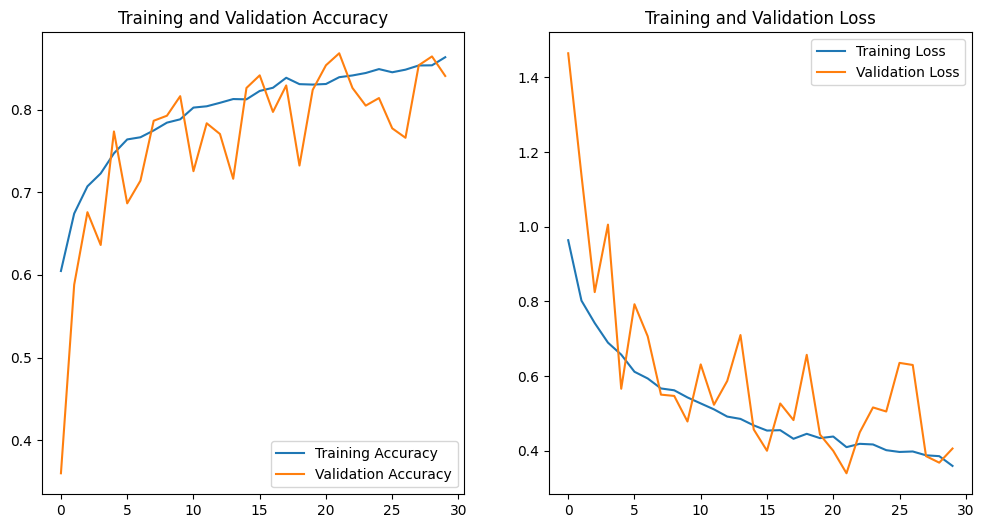

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot training results
plot_training(history)

# Save the model
model.save('ConvAttenMixer_brain_tumor.h5')


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load an image for prediction
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image
    return img_array

# Make a prediction
def predict_brain_tumor(img_path):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)

    # The model output will be probabilities for each class
    predicted_class = np.argmax(prediction, axis=1)[0]  # Get class with highest probability

    class_labels = ['No tumor', 'Glioma', 'Meningioma', 'Pituitary tumor']
    print(f"Predicted class: {class_labels[predicted_class]} with confidence: {np.max(prediction) * 100:.2f}%")

# Example usage:
# Replace with the path to an MRI image for prediction
img_path = 'meningioma.jpg'
predict_brain_tumor(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Predicted class: Meningioma with confidence: 96.11%


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, BatchNormalization, Add, MultiHeadAttention, LayerNormalization
)

# Self-Attention Block
def self_attention_block(x, num_heads=4, output_channels=None):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    if output_channels and x.shape[-1] != output_channels:
        attention_output = Conv2D(output_channels, kernel_size=1, padding="same")(attention_output)
    x = Add()([x, attention_output])
    x = LayerNormalization()(x)
    return x

# External Attention Block
def external_attention_block(x, filters=None):
    external_memory = Conv2D(filters, kernel_size=1, padding="same")(x)
    attention_output = Conv2D(filters, kernel_size=1, padding="same")(external_memory)
    x = Add()([x, attention_output])
    x = LayerNormalization()(x)
    return x

# U-Net with Attention
def unet_with_attention(input_shape):
    inputs = Input(input_shape)

    # Encoder: Downsampling path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = self_attention_block(c2, output_channels=128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = external_attention_block(c3, filters=256)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    b = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    b = BatchNormalization()(b)
    b = Conv2D(512, (3, 3), activation='relu', padding='same')(b)
    b = BatchNormalization()(b)
    b = self_attention_block(b, output_channels=512)

    # Decoder: Upsampling path
    u3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(b)
    c3_resized = Conv2D(256, (1, 1), activation='relu', padding='same')(c3)  # Adjust channels
    u3 = Concatenate()([u3, c3_resized])
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(u3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = external_attention_block(c4, filters=256)

    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    c2_resized = Conv2D(128, (1, 1), activation='relu', padding='same')(c2)  # Adjust channels
    u2 = Concatenate()([u2, c2_resized])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    u1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    c1_resized = Conv2D(64, (1, 1), activation='relu', padding='same')(c1)  # Adjust channels
    u1 = Concatenate()([u1, c1_resized])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c6)  # Sigmoid for binary segmentation
    return tf.keras.Model(inputs, outputs)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# Define a Self-Attention Block
def self_attention_block(inputs, num_heads=4):
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = layers.Add()([inputs, attention_output])  # Residual Connection
    attention_output = layers.LayerNormalization()(attention_output)
    return attention_output

# Define a Downsampling Block
def unet_down_block(inputs, filters, kernel_size=3, pool_size=2, add_attention=False):
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    if add_attention:
        x = self_attention_block(x)
    pooled = layers.MaxPooling2D(pool_size)(x)
    return x, pooled

# Define an Upsampling Block
def unet_up_block(inputs, skip_connection, filters, kernel_size=3, add_attention=False):
    x = layers.Conv2DTranspose(filters, kernel_size, strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.Concatenate()([x, skip_connection])
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    if add_attention:
        x = self_attention_block(x)
    return x

# Define UNet with Self-Attention
def create_unet_with_attention(input_shape=(224, 224, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Encoder
    s1, p1 = unet_down_block(inputs, 64, add_attention=True)  # Add self-attention here
    s2, p2 = unet_down_block(p1, 128, add_attention=True)     # Add self-attention here
    s3, p3 = unet_down_block(p2, 256)
    s4, p4 = unet_down_block(p3, 512)

    # Bridge
    bridge = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(p4)
    bridge = layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(bridge)

    # Decoder
    u3 = unet_up_block(bridge, s4, 512)
    u2 = unet_up_block(u3, s3, 256)
    u1 = unet_up_block(u2, s2, 128, add_attention=True)  # Add self-attention here
    u0 = unet_up_block(u1, s1, 64, add_attention=True)   # Add self-attention here

    # Output
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(u0)

    return models.Model(inputs, outputs)

# Input and classes
input_shape = (224, 224, 3)
num_classes = 4

# Initialize the model
model = create_unet_with_attention(input_shape, num_classes=num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 224, 224, 64)   │         66,368 │ conv2d_1[0][0],        │
│ (MultiHeadAttention)      │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 64)   │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 224, 224, 64)   │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ layer_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 112, 112, 128)  │        263,808 │ conv2d_3[0][0],        │
│ (MultiHeadAttention)      │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 112, 112, 128)  │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 112, 112, 128)  │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ layer_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 35,174,660 (134.18 MB)

 Trainable params: 35,174,660 (134.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("Model output shape:", model.output_shape)
print("Label shape:", train_generator[0][1].shape)

Model output shape: (None, 224, 224, 4)
Label shape: (32,)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None,), output.shape=(None, 224, 224, 4)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision
set_global_policy('mixed_float16')

# Simple Self-Attention Block
def simple_self_attention(inputs):
    """Simple Self-Attention block."""
    # Linear projections for query, key, and value
    query = layers.Conv2D(inputs.shape[-1], (1, 1))(inputs)
    key = layers.Conv2D(inputs.shape[-1], (1, 1))(inputs)
    value = layers.Conv2D(inputs.shape[-1], (1, 1))(inputs)

    # Compute attention map
    attention_map = layers.Multiply()([query, key])
    attention_map = layers.Softmax(axis=-1)(attention_map)

    # Apply attention to value
    attention_output = layers.Multiply()([attention_map, value])

    return attention_output

# Define Downsampling Block with Simple Self-Attention
def unet_down_block(inputs, filters, kernel_size=3, pool_size=2, add_attention=False):
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    if add_attention:
        x = simple_self_attention(x)  # Apply simple self-attention
    pooled = layers.MaxPooling2D(pool_size)(x)
    return x, pooled

# Define Upsampling Block
def unet_up_block(inputs, skip_connection, filters, kernel_size=3):
    # Align the number of channels between the skip connection and upsampled tensor
    skip_connection = layers.Conv2D(filters, (1, 1), padding='same')(skip_connection)

    # Upsample the tensor
    x = layers.Conv2DTranspose(filters, kernel_size, strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.Concatenate()([x, skip_connection])
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    return x

# Define Classification Head
def classification_head(inputs, num_classes):
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Dense(128, activation='relu')(x)  # Reduce dense layer size
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return outputs

# Define UNet with Simple Self-Attention for Classification
def create_unet_with_attention(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Encoder
    s1, p1 = unet_down_block(inputs, 32, add_attention=True)
    s2, p2 = unet_down_block(p1, 64, add_attention=True)
    s3, p3 = unet_down_block(p2, 128)
    s4, p4 = unet_down_block(p3, 256)

    # Bridge (Bottleneck layer)
    bridge = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(p4)

    # Decoder
    u3 = unet_up_block(bridge, s4, 256)
    u2 = unet_up_block(u3, s3, 128)
    u1 = unet_up_block(u2, s2, 64)
    u0 = unet_up_block(u1, s1, 32)

    # Classification head
    outputs = classification_head(u0, num_classes)

    return models.Model(inputs, outputs)

# Input and classes
input_shape = (128, 128, 3)
num_classes = 4

# Initialize the model
model = create_unet_with_attention(input_shape, num_classes=num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'btds/Training'
val_dir = 'btds/Testing'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=8,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=8,
    class_mode='sparse'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator
)

# Save the model
model.save('optimized_unet_with_simple_attention.h5')


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/100
714/714 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.3852 - loss: 1.2389 - val_accuracy: 0.5561 - val_loss: 1.0866
Epoch 2/100
714/714 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.6533 - loss: 0.8778 - val_accuracy: 0.5927 - val_loss: 1.0431
Epoch 3/100
714/714 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.6771 - loss: 0.7872 - val_accuracy: 0.6682 - val_loss: 0.8005
Epoch 4/100
714/714 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.6842 - loss: 0.7463 - val_accuracy: 0.6537 - val_loss: 0.8815
Epoch 5/100
714/714 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7041 - loss: 0.7268 - val_accuracy: 0.7063 - val_loss: 0.7399
Epoch 6/100
714/714 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.7455 - loss: 0.6723 - val_accuracy: 0.7292 - val_loss: 0.6967
Epoch 7/100
714/714 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.7612 - loss: 0.6539 - val_accuracy: 0.6651 - val_loss: 0.7486

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7875 - loss: 0.4738
Validation Accuracy: 79.63%


In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8252 - loss: 0.3920
Validation Accuracy: 82.99%


In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8722 - loss: 0.3685
Validation Accuracy: 86.50%


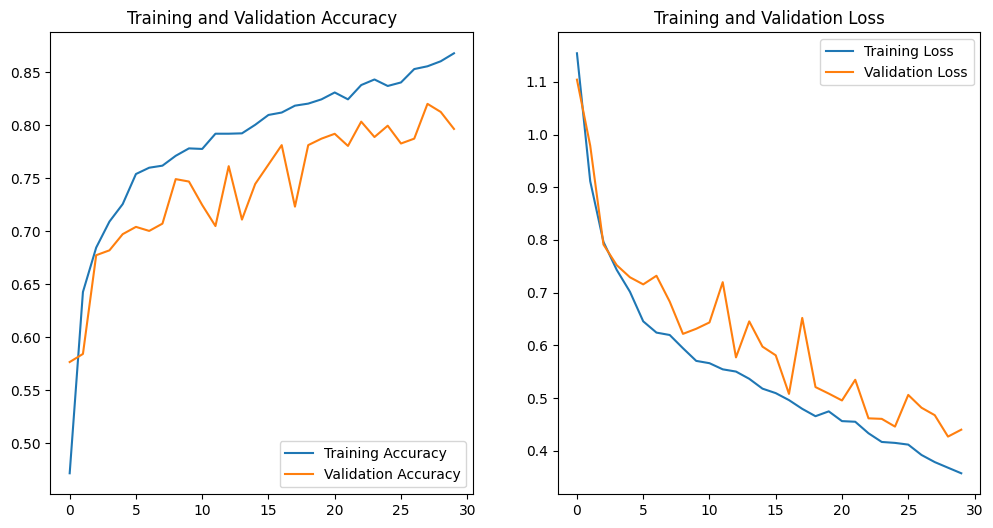

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot training results
plot_training(history)


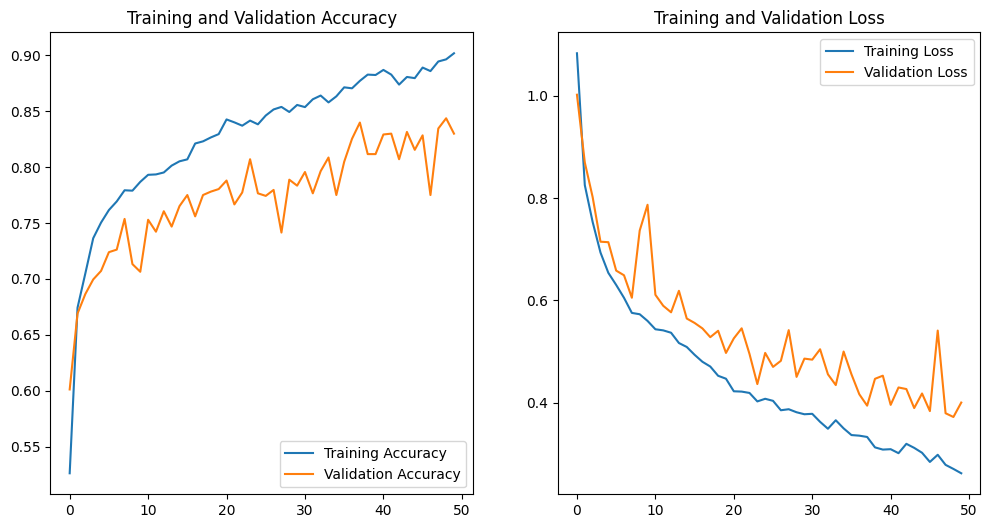

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot training results
plot_training(history)


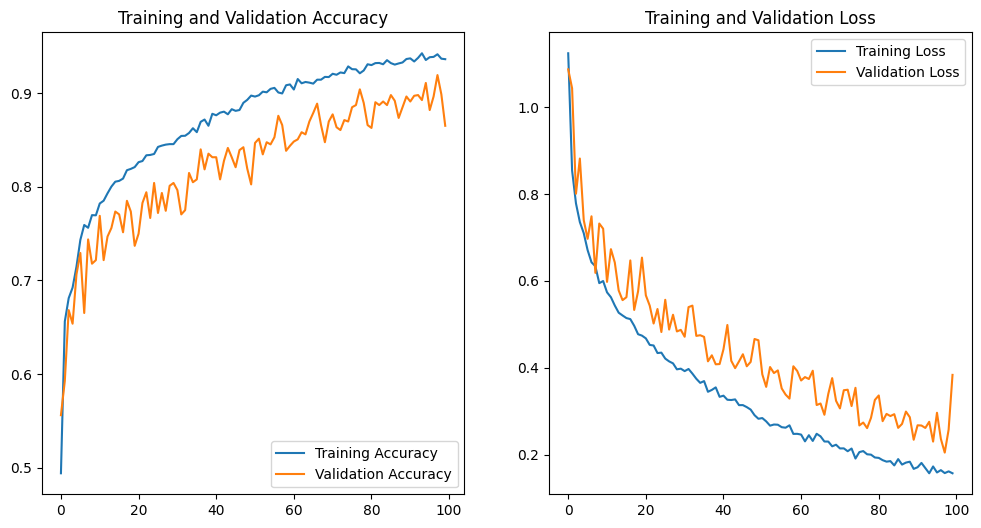

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot training results
plot_training(history)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the Model
def create_unet_with_attention(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Encoder
    s1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(s1)

    s2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(p1)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(s2)

    # Bridge
    bridge = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(p2)

    # Decoder
    u2 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(bridge)
    u2 = layers.Concatenate()([u2, s2])
    u1 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(u2)
    u1 = layers.Concatenate()([u1, s1])

    # Classification Head
    outputs = layers.GlobalAveragePooling2D()(u1)
    outputs = layers.Dense(num_classes, activation='softmax')(outputs)

    return models.Model(inputs, outputs)

# Initialize the model
model = create_unet_with_attention(input_shape=(128, 128, 3), num_classes=4)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_dir = 'btds/Training'
val_dir = 'btds/Testing'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Reduced size
    batch_size=16,  # Reduced batch size
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),  # Reduced size
    batch_size=16,  # Reduced batch size
    class_mode='sparse'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

# Save the model
model.save('unet_with_attention_optimized.h5')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 34s 60ms/step - accuracy: 0.3763 - loss: 1.1988 - val_accuracy: 0.6331 - val_loss: 1.0524
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.6753 - loss: 0.8582 - val_accuracy: 0.6674 - val_loss: 0.8621
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.7126 - loss: 0.7353 - val_accuracy: 0.7086 - val_loss: 0.7382
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.7339 - loss: 0.6767 - val_accuracy: 0.6552 - val_loss: 0.9724
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.7823 - loss: 0.5822 - val_accuracy: 0.7391 - val_loss: 0.7141
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7887 - loss: 0.5323 - val_accuracy: 0.7338 - val_loss: 0.7193
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.7941 - loss: 0.5127 - val_accuracy: 0.7460 - val_loss: 0.6119
Epoch 

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8217 - loss: 0.3999
Validation Accuracy: 82.84%


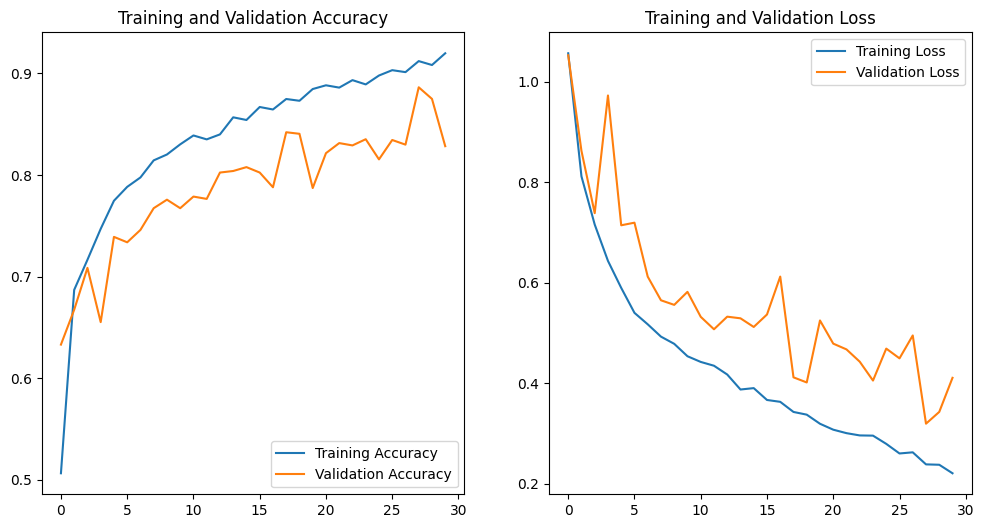

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot training results
plot_training(history)

# Save the model
model.save('ConvAttenMixer_brain_tumor.h5')